In [ ]:
# google cloud lib req
#!pip install --user gcsfs statsmodels

In [3]:
# Import Libraries
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import itertools
import warnings
warnings.filterwarnings("ignore")

In [4]:
#  Load the Data using Apple’s stock price data over the last 10 years, stored in a Google Cloud Storage bucket.
#df = pd.read_csv('gs://cloud-training/ai4f/AAPL10Y.csv')
df = pd.read_csv('GoogleStockPrice.csv')
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values('Date', inplace=True)
df.set_index('Date', inplace=True)
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2013-01-02,18.003504,18.193193,17.931683,18.099348,18.099348,101550348
2013-01-03,18.141392,18.316566,18.036036,18.109859,18.109859,92635272
2013-01-04,18.251753,18.555305,18.210211,18.467718,18.467718,110429460
2013-01-07,18.404655,18.503002,18.282784,18.387136,18.387136,66161772
2013-01-08,18.406906,18.425926,18.128880,18.350851,18.350851,66976956


In [5]:
# Select only the specified columns
df_selected = df[['Close']]
# Display the result
df_selected.head()

,Close
Date,
2013-01-02,18.099348
2013-01-03,18.109859
2013-01-04,18.467718
2013-01-07,18.387136
2013-01-08,18.350851


In [6]:
# Resample the data to weekly frequency and take the mean of 'close'
#df['close'] = pd.to_numeric(df['close'], errors='coerce')# Convert 'close' to numeric in case it's not in numeric format
df_week = df_selected.resample('W').mean()
df_week.head()

,Close
Date,
2013-01-06,18.225642
2013-01-13,18.456657
2013-01-20,17.913914
2013-01-27,18.470032
2013-02-03,18.966616


In [7]:
#  computing the logarithmic weekly returns to normalize the data.
df_week['weekly_ret'] = np.log(df_week['Close']).diff()
df_week.dropna(inplace=True)
df_week.head()

,Close,weekly_ret
Date,,
2013-01-13,18.456657,0.012596
2013-01-20,17.913914,-0.029847
2013-01-27,18.470032,0.030572
2013-02-03,18.966616,0.026531
2013-02-10,19.290540,0.016934


# Exploratory Data Analysis

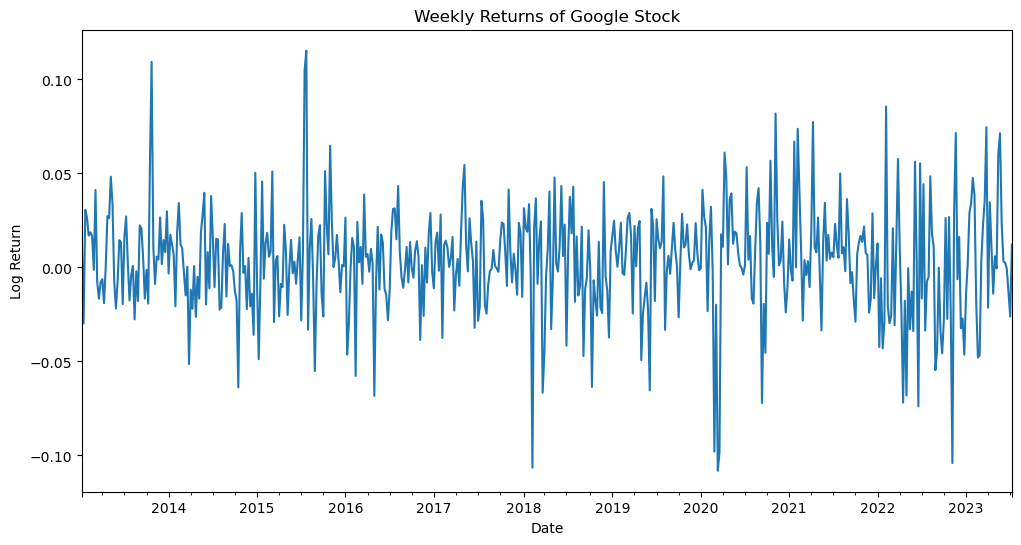

In [8]:
# visualizing the weekly returns.
df_week['weekly_ret'].plot(kind='line', figsize=(12, 6))
plt.title('Weekly Returns of Google Stock')
plt.ylabel('Log Return')
plt.show()

# Testing for Stationarity
- stationary time series has a constant mean and variance over time, which is a prerequisite for ARIMA modelling.
- computing the rolling mean and standard deviation.

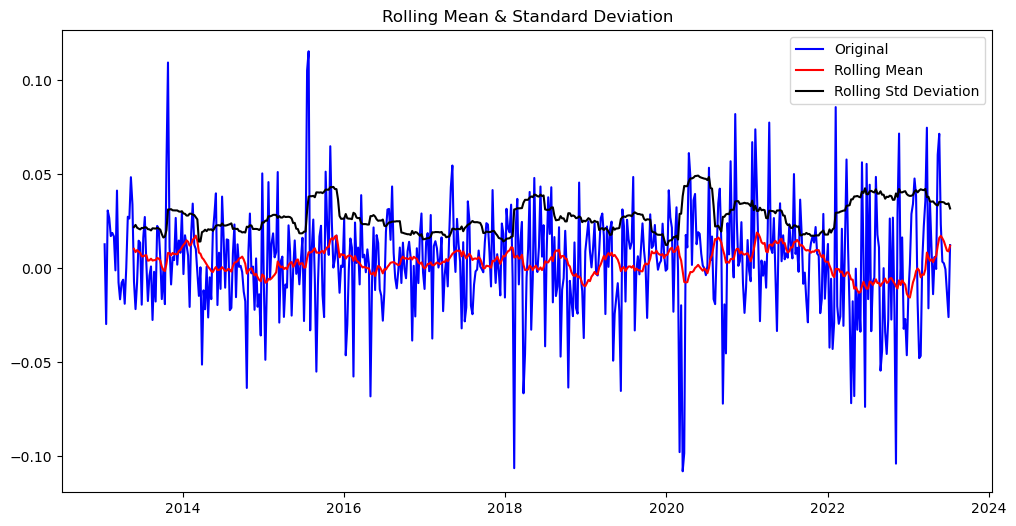

In [9]:
rolmean = df_week['weekly_ret'].rolling(window=20).mean()
rolstd = df_week['weekly_ret'].rolling(window=20).std()

plt.figure(figsize=(12, 6))
plt.plot(df_week['weekly_ret'], color='blue', label='Original')
plt.plot(rolmean, color='red', label='Rolling Mean')
plt.plot(rolstd, color='black', label='Rolling Std Deviation')
plt.title('Rolling Mean & Standard Deviation')
plt.legend()
plt.show()

In [10]:
# Augmented Dickey-Fuller test to statistically check stationarity.
dftest = sm.tsa.adfuller(df_week['weekly_ret'], autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '# Lags Used', 'Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput[f'Critical Value ({key})'] = value
print(dfoutput)

Test Statistic                -1.616252e+01
p-value                        4.450452e-29
# Lags Used                    1.000000e+00
Number of Observations Used    5.460000e+02
Critical Value (1%)           -3.442384e+00
Critical Value (5%)           -2.866848e+00
Critical Value (10%)          -2.569597e+00
dtype: float64


**Interpretation:**
- If the p-value is less than 0.05, the time series is stationary.

- Test Statistic: The test statistic is approximately -16.16, which is much lower than any of the critical values at the 1%, 5%, and 10% significance levels.
- p-value: The p-value is extremely low (3.61×10 −27), which is well below the typical significance levels (e.g., 0.05 or 0.01). **This indicates that we can reject the null hypothesis of non-stationarity.**
- Critical Values: The test statistic is significantly lower than the critical values at all tested levels (1%, 5%, and 10%), reinforcing the conclusion that the data is stationary.
  
**In summary, Since the Test Statistic is much lower than all the critical values, it further confirms that the null hypothesis is rejected. This likely means the time series is stationary, which is essential for reliable ARIMA modelling.**

# Identifying ARIMA Parameters
- to identify the optimal ARIMA parameters (p, d, q) for the  dataset.
- This process involves using the Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) plots to help determine suitable values for p and q, while d is set based on the stationarity of the data.
- ACF and PACF Analysis: These plots help us visually decide on the values of p and q. The ACF shows the correlation of a time series with its lagged values, helping identify the q parameter, and the PACF helps determine p

In [11]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import acf, pacf

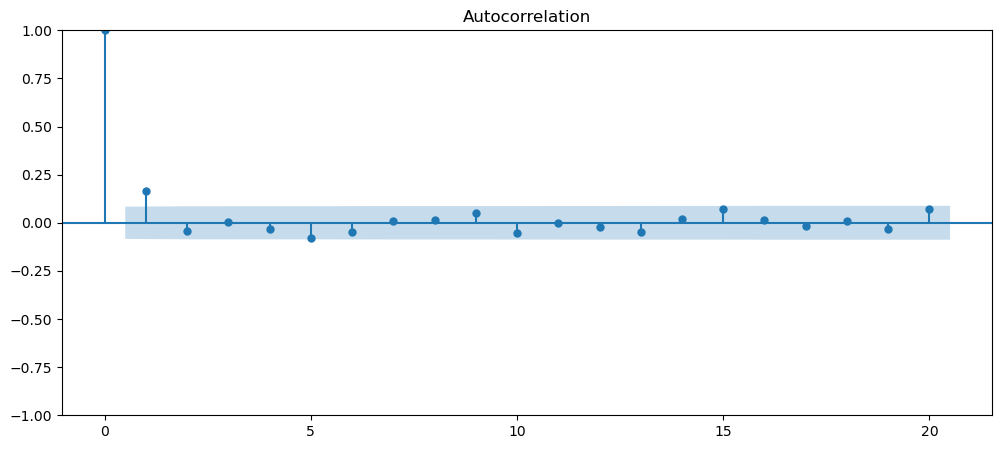

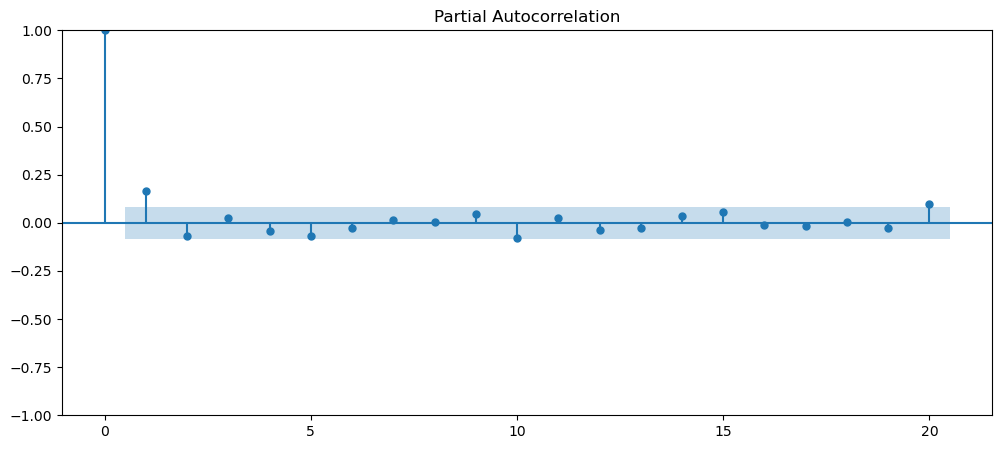

In [12]:
# Step 1: Plot ACF to estimate q
fig, ax = plt.subplots(figsize=(12,5))
plot_acf(df_week['weekly_ret'], lags=20, ax=ax)
plt.show()

# Step 2: Plot PACF to estimate p
fig, ax = plt.subplots(figsize=(12,5))
plot_pacf(df_week['weekly_ret'], lags=20, ax=ax)
plt.show()

In [13]:
acf_values = acf(df_week['weekly_ret'], nlags=20)  # Adjust `nlags` as needed
pacf_values = pacf(df_week['weekly_ret'], nlags=20)  # Adjust `nlags` as needed

# Display the values
acf_values_df = pd.DataFrame({'Lag': range(len(acf_values)), 'ACF': acf_values})
pacf_values_df = pd.DataFrame({'Lag': range(len(pacf_values)), 'PACF': pacf_values})
print("ACF values:\n", acf_values_df)
print("\nPACF values:\n", pacf_values_df)

ACF values:
     Lag       ACF
0     0  1.000000
1     1  0.163530
2     2 -0.040568
3     3  0.006148
4     4 -0.034048
5     5 -0.079658
6     6 -0.047831
7     7  0.010522
8     8  0.012908
9     9  0.048855
10   10 -0.053644
11   11 -0.001025
12   12 -0.022407
13   13 -0.046601
14   14  0.020475
15   15  0.072439
16   16  0.014864
17   17 -0.017671
18   18  0.008314
19   19 -0.033137
20   20  0.072971

PACF values:
     Lag      PACF
0     0  1.000000
1     1  0.163829
2     2 -0.069420
3     3  0.025493
4     4 -0.043992
5     5 -0.067542
6     6 -0.028350
7     7  0.016902
8     8  0.005363
9     9  0.046561
10   10 -0.081280
11   11  0.024140
12   12 -0.037165
13   13 -0.030148
14   14  0.036061
15   15  0.058583
16   16 -0.010737
17   17 -0.016276
18   18  0.003148
19   19 -0.027884
20   20  0.100817


*Observation*
- ACF and PACF Analysis: These plots help us visually decide on the values of p and q. The ACF shows the correlation of a time series with its lagged values, helping identify the q parameter, and the PACF helps determine p.
- Based on the ACF and PACF patterns:
- 𝑝 values:𝑝=1: Noticeable spike at lag 1 in PACF.𝑝=3: Slightly visible spike at lag 3 in PACF.
- 𝑞 values:𝑞=1: Noticeable spike at lag 1 in ACF. 𝑞=9: Another noticeable spike at lag 9 in ACF.
- These values should give  a good starting point for model selection.

# Hyperparameter Tuning
- to automate finding the best (p, d, q), we can run a grid search over a range of values and select the parameters with the lowest AIC (Akaike Information Criterion) and MSE (Mean Squared Error).
- To enhance ARIMA model selection process by incorporating Mean Squared Error (MSE) along with Akaike Information Criterion (AIC).
- This approach ensures that I select the best ARIMA model based on both AIC (which indicates model fit) and MSE (which measures forecasting accuracy).
- divide the dataset into a training set (60%) and a testing set (40%).
- fit model on the training set and forecast values for the testing set.bMSE is calculated between the actual test values and the predicted values.
- model with the lowest AIC is retained. In case of ties in AIC, it favours the one with the lowest MSE.

In [14]:
# Assuming df_week is your DataFrame and 'weekly_ret' is the column of interest
# Set initial range for p, d, and q
p = range(0, 9)  # Adjust range if necessary
d = range(0, 1)  # Typically, d = 0 or 1 if data is stationary
q = range(0, 9)

# Prepare to store the best results
best_aic = float("inf")
best_mse = float("inf")
best_order = None

# Grid search over the p, d, q values
for i in p:
    for j in d:
        for k in q:
            try:
                # Fit the ARIMA model
                model = ARIMA(df_week['weekly_ret'], order=(i, j, k))
                model_fit = model.fit()

                # Calculate AIC
                aic = model_fit.aic

                # Make predictions for MSE calculation (using the last 10% of the data as test set)
                train_size = int(len(df_week) * 0.9)
                train, test = df_week['weekly_ret'][:train_size], df_week['weekly_ret'][train_size:]
                model = ARIMA(train, order=(i, j, k))
                model_fit = model.fit()

                # Forecast the test set
                predictions = model_fit.forecast(steps=len(test))
                mse = mean_squared_error(test, predictions)

                # Check for best AIC and MSE
                if aic < best_aic or (aic == best_aic and mse < best_mse):
                    best_aic = aic
                    best_mse = mse
                    best_order = (i, j, k)

            except Exception as e:
                # Catch exceptions related to model fitting
                continue

print(f"Best ARIMA order: {best_order} with AIC: {best_aic} and MSE: {best_mse}")

Best ARIMA order: (0, 0, 1) with AIC: -2355.8471492375356 and MSE: 0.0013435579440343184


# Fit the Best ARIMA Model

In [15]:
# Fit model with best (p, d, q) parameters
best_model = ARIMA(df_week['weekly_ret'], order=best_order).fit()
print(best_model.summary())

                               SARIMAX Results                                
Dep. Variable:             weekly_ret   No. Observations:                  548
Model:                 ARIMA(0, 0, 1)   Log Likelihood                1180.924
Date:                Sun, 03 Nov 2024   AIC                          -2355.847
Time:                        19:06:11   BIC                          -2342.928
Sample:                    01-13-2013   HQIC                         -2350.798
                         - 07-09-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0035      0.001      2.428      0.015       0.001       0.006
ma.L1          0.1802      0.035      5.090      0.000       0.111       0.250
sigma2         0.0008   3.54e-05     22.188      0.0

In [ ]:
# Fit model with best (p, d, q) parameters
#best_p, best_d, best_q = best_model[0]
#best_model = ARIMA(df_week['weekly_ret'], order=(best_p, best_d, best_q)).fit()
#print(best_model.summary())

Ljung-Box Test (L1, Q): The Ljung-Box Q statistic tests for autocorrelation in the residuals at lag 1.
- With a Q-statistic close to 0 and a high p-value (0.95), there’s no evidence of autocorrelation in the residuals, suggesting that the model captures the autocorrelation structure well.
- Kurtosis: 4.61 This measures the "tailedness" of the distribution. A value greater than 3 indicates a heavier tail than a normal distribution.

Overall, the model fits the data reasonably well, but there are indications of non-normality in the residuals and potential heteroskedasticity. Might have to consider model diagnostics further or explore different specifications or transformations of the data to address these issues.

# Model Evaluation
- Residual Analysis
- Forecast Future Values
- Inverse Transform to Price

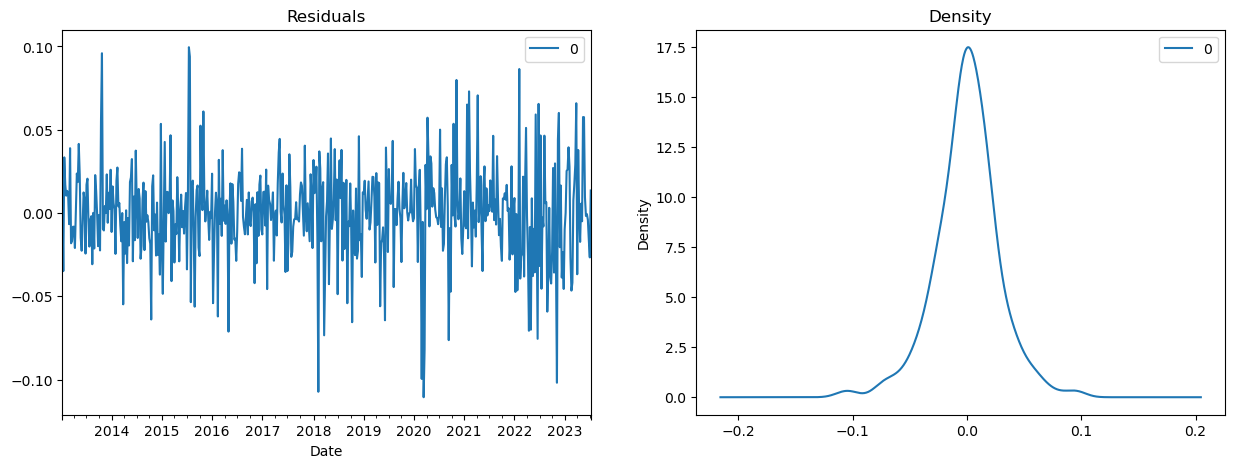

In [16]:
# Residual Analysis: to ensure they are randomly distributed (white noise).

residuals = pd.DataFrame(best_model.resid)
fig, ax = plt.subplots(1,2, figsize=(15,5))
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

Residual Plot: Shows how well the ARIMA model fits the data over time. The residuals (errors) fluctuate around zero without an obvious pattern, which is a good sign. It means the model's doing a decent job.

Density Plot: Shows the distribution of these residuals. Most residuals are close to zero and the shape of the plot looks roughly symmetric, which suggests that the residuals are normally distributed. This is also a positive indicator that the model’s assumptions hold true.

Both plots show that the ARIMA model has captured the data's structure well.

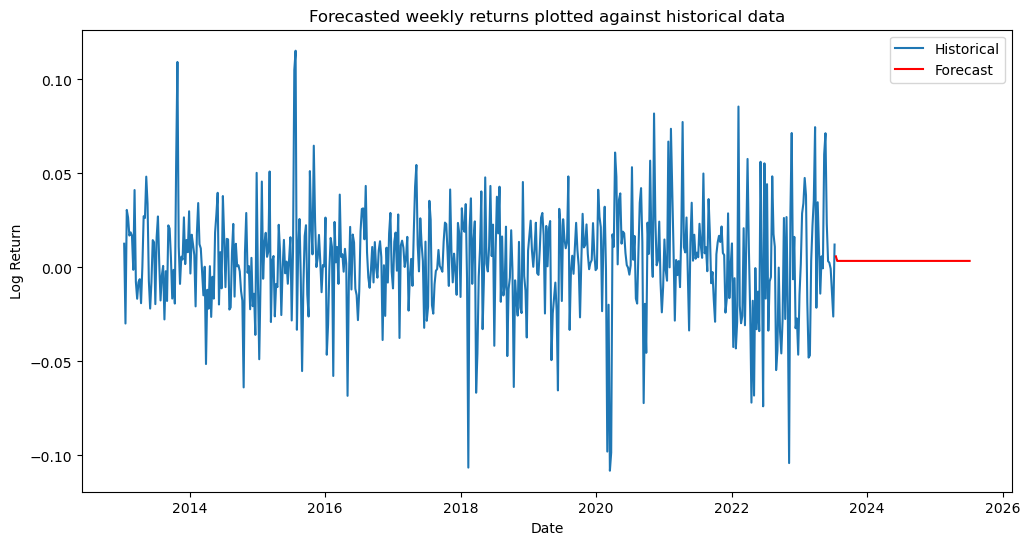

In [24]:
forecast_steps = 104
forecast = best_model.forecast(steps=forecast_steps)

plt.figure(figsize=(12, 6))
plt.plot(df_week['weekly_ret'], label='Historical')
plt.plot(forecast.index, forecast, label='Forecast', color='red')
plt.title('Forecasted weekly returns plotted against historical data')
plt.xlabel('Date')
plt.ylabel('Log Return')
plt.legend()
plt.show()

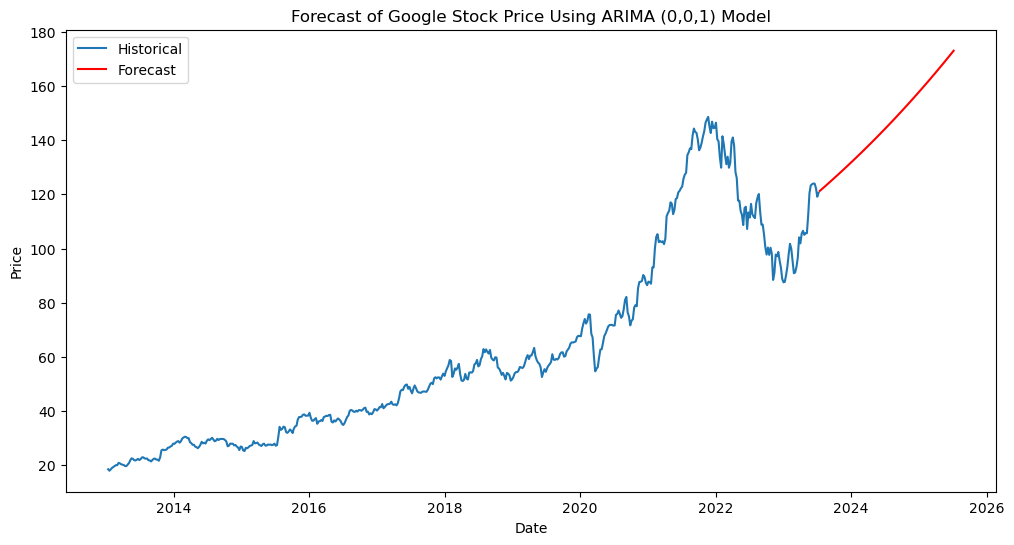

In [26]:
# Inverse Transform to Price: To make the forecast interpretable, we convert the returns back to price levels.
last_close = df_week['Close'][-1]
forecast_prices = last_close * np.exp(np.cumsum(forecast))

plt.figure(figsize=(12, 6))
plt.plot(df_week['Close'], label='Historical')
plt.plot(forecast.index, forecast_prices, label='Forecast', color='red')
plt.title('Forecast of Google Stock Price Using ARIMA (0,0,1) Model')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [28]:
# Print the forecasted values
print("Forecasted Returns for the Next 104 Weeks:")
forecast_prices

Forecasted Returns for the Next 104 Weeks:


2023-07-16    121.298289
2023-07-23    121.717594
2023-07-30    122.138349
2023-08-06    122.560558
2023-08-13    122.984227
                 ...    
2025-06-08    170.696468
2025-06-15    171.286533
2025-06-22    171.878639
2025-06-29    172.472791
2025-07-06    173.068997
Freq: W-SUN, Name: predicted_mean, Length: 104, dtype: float64

# Results and Findings
- The optimal ARIMA model identified was ARIMA(0, 0, 1), achieving the lowest MSE of 0.0013.
- The model's residuals are randomly distributed, signalling a good fit.
- The forecast indicates a specific upward trend in Google stock returns and prices over the upcoming 104 weeks.
- The model successfully captures the data’s underlying patterns, but like any model, it comes with its limitations and assumptions.

# Conclusion
- I created a model using ARIMA with hyperparameter tuning to forecast Google's weekly stock returns. This highlights the critical role of data preparation, stationarity testing, and parameter optimization in time series forecasting. While the model offers valuable insights, it's important to recognize that stock markets are subject to many unpredictable factors, and no model can provide guaranteed predictions.